In [18]:
# TODO: replace df with dataframe
# TODO: investigate presence of multiple 'Plate ID' columns in condition_summary
# TODO: add dataset selector (or make new notebooks for analyzing different datasets - this might be better, think about it.)

In [19]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn.apionly as sns
import numpy as np
import pandas as pd
import IPython.html.widgets as widgets

from scipy.stats import \
    ks_2samp,\
    ranksums
    
from IPython.html.widgets import \
    interact,\
    fixed

from IPython.display import \
    display

from pandas.tools.plotting import \
    scatter_matrix

from pandas import \
    DataFrame as df

from view import \
    plot_plates,\
    matrix_tree
    
from toolz import \
    pipe,\
    thread_first,\
    thread_last
    
from utils import \
    normalize_columns,\
    filter_and_drop,\
    filter_rows,\
    fst,\
    snd,\
    add_col,\
    get_files,\
    gen_filenames,\
    maybe_get_model,\
    persist_widget_value,\
    format_timestamp,\
    concatenate,\
    unzip

from collections import \
    OrderedDict

In [20]:
colors = {'Blue & Red':'bwr','Blue':'Blues','None': None}

In [21]:
model_filepath = '/notebooks/tmp/ui-model.json'
uiget = maybe_get_model(model_filepath) # key -> value
uiset = persist_widget_value(model_filepath) # widget -> key

# Select Plate
Select plate below, then click `Cell -> Run All` in the menu above to update all the charts. 

In [22]:
# DataFrame -> String -> Int -> DataFrame
def get_selected_data(d,recipe,timestamp):
    """ Return dataframe where recipe and timestamp take given value. """
    return d[(d['Image Analysis Recipe'] == recipe) & 
             (d['Upload Timestamp'] == timestamp)]

In [23]:
all_cells = pd.read_csv('/notebooks/moldev-data/db/db.csv')

In [24]:
plate_groups = thread_last(
    all_cells.groupby(['Image Analysis Recipe', 'Upload Timestamp']),
    (map, fst),
    lambda xs: sorted(xs, key = snd, reverse = True))

plate_labels = ["{} | {}".format(recipe,format_timestamp(timestamp)) \
                   for recipe, timestamp in plate_groups]

plate_selection_dict = OrderedDict(zip(plate_labels, plate_groups))

In [25]:
init_plate_value = tuple(uiget('plate_selection_groups', plate_groups[0]))
if init_plate_value not in plate_selection_dict.values():
    init_plate_value = plate_selection_dict.values()[0]

plate_selector = widgets.Dropdown(
    options = plate_selection_dict,
    value = init_plate_value)

uiset(plate_selector,'plate_selection_groups')
display(plate_selector)

In [26]:
# Import data
cells = get_selected_data(all_cells,*plate_selector.value)

In [27]:
# Create dataframe to compare cells with different phases

# DataFrame -> DataFrame
def get_cells_with_phase(dataframe):
    """ Concatenate original dataframe with new dataframe 
        generated by adding cell phase to Condition to column. """
    original = dataframe
    with_phases = dataframe.copy()
    
    if with_phases['Cell Phase'].isnull().all():
        return original
    else: 
        with_phases['Condition'] = with_phases['Condition'] + ' ' + with_phases['Cell Phase']
        return pd.concat([original,with_phases])
    
cells_with_phase = get_cells_with_phase(cells)

In [28]:
# Group columns into separate categories
cell_cols = ['Cell ID', 'Cell SID', 'Cell Type', 'Cell Phase', 'MEASUREMENT SET ID', 'ObjectID', 'Site ID','Threshold']
well_cols = ['Contents', 'Units (concentration)','Concentration', 'Condition', 'Well Name', 'time', 'Units (time)']
plate_cols = ['Assay', 'Experiment Name', 'Image Analysis Date', 'Image Analysis Recipe', 'Image Collection Date', 'Investigator', 'Layout File', 'Magnification', 'Plate File', 'Plate ID', 'Upload Timestamp']
non_param_cols = concatenate([cell_cols, well_cols, plate_cols])
param_cols_without_cell_count = sorted(list(set(cells.columns.tolist()).difference(set(non_param_cols))))
param_cols = ['Cell Count'] + param_cols_without_cell_count 

In [29]:
# Generate well summary data
well_means = cells[param_cols_without_cell_count + ['Well Name']].groupby('Well Name').mean().reset_index()

well_cell_counts = thread_last(
    cells.groupby('Well Name'),
    (map, lambda x: {'Well Name': x[0],
                     'Cell Count': len(x[1]),
                     'Condition': x[1].iloc[0]['Condition'],
                     'Plate ID': x[1].iloc[0]['Plate ID']}),
    pd.DataFrame)

wells = pd.merge(well_means, well_cell_counts, on = 'Well Name')

In [30]:
# Generate condition summary data
condition_means = cells[param_cols_without_cell_count + ['Condition']].groupby('Condition').mean().reset_index()

condition_cell_counts = thread_last(
    cells.groupby('Condition'),
    (map, lambda x: {'Condition': x[0],
                     'Cell Count': len(x[1])}),
    pd.DataFrame)

conditions = pd.merge(condition_means, condition_cell_counts, on = 'Condition')

In [31]:
condition_names = cells.sort(['Assay','Cell Type','Contents','Concentration'])['Condition'].unique().tolist()
condition_names_with_phase = cells_with_phase.sort(['Assay','Cell Type','Contents','Concentration'])['Condition'].unique().tolist()

def get_parameter_widget(init_val = 'Cell Count'):
    return widgets.Select(
        value = init_val,
        options = param_cols,
        height = 250)

def get_parameter_widget_multiple(init_val = param_cols, options = param_cols):
    return widgets.SelectMultiple(
        value = init_val,
        options = param_cols,
        height = 250)

def get_condition_widget_multiple(init_val = condition_names):
    return widgets.SelectMultiple(
        value = init_val,
        options = condition_names, 
        height = 300)

def get_color_widget(init_val = colors['Blue & Red']):
    return widgets.ToggleButtons(
        value = init_val,
        options = colors)

---
# Well Plate Results

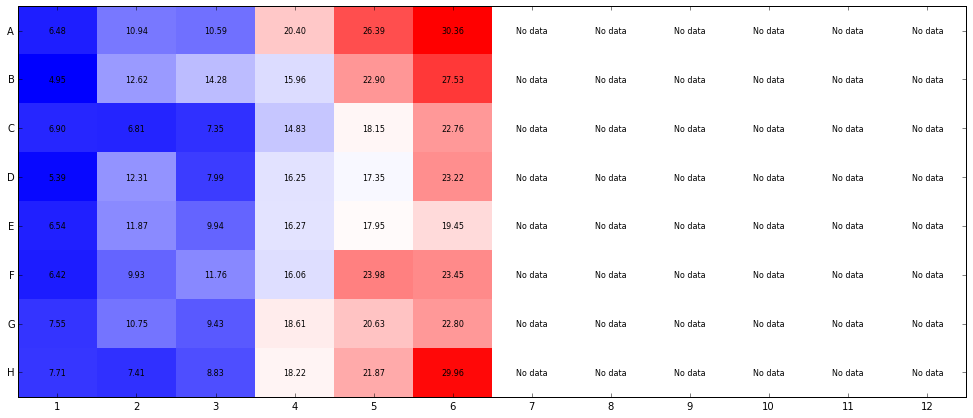

In [32]:
%matplotlib inline
interact(plot_plates, 
         dataframe = fixed(wells),
         parameter = get_parameter_widget(),
         color = get_color_widget(),
         show = widgets.ToggleButtons(options=['Values','Conditions','None']));

---
# How do conditions cluster together?

In [33]:
normalized_condition_data = \
    pipe(conditions.set_index('Condition'),
    normalize_columns(fillna=True))

#normalized_condition_data = normalized_condition_data.drop('Threshold',axis=1)
    
data_without_empty_params = normalized_condition_data.dropna(axis=1,how='all')

In [34]:
params_without_data = sorted(set(normalized_condition_data.columns).difference(data_without_empty_params.columns))

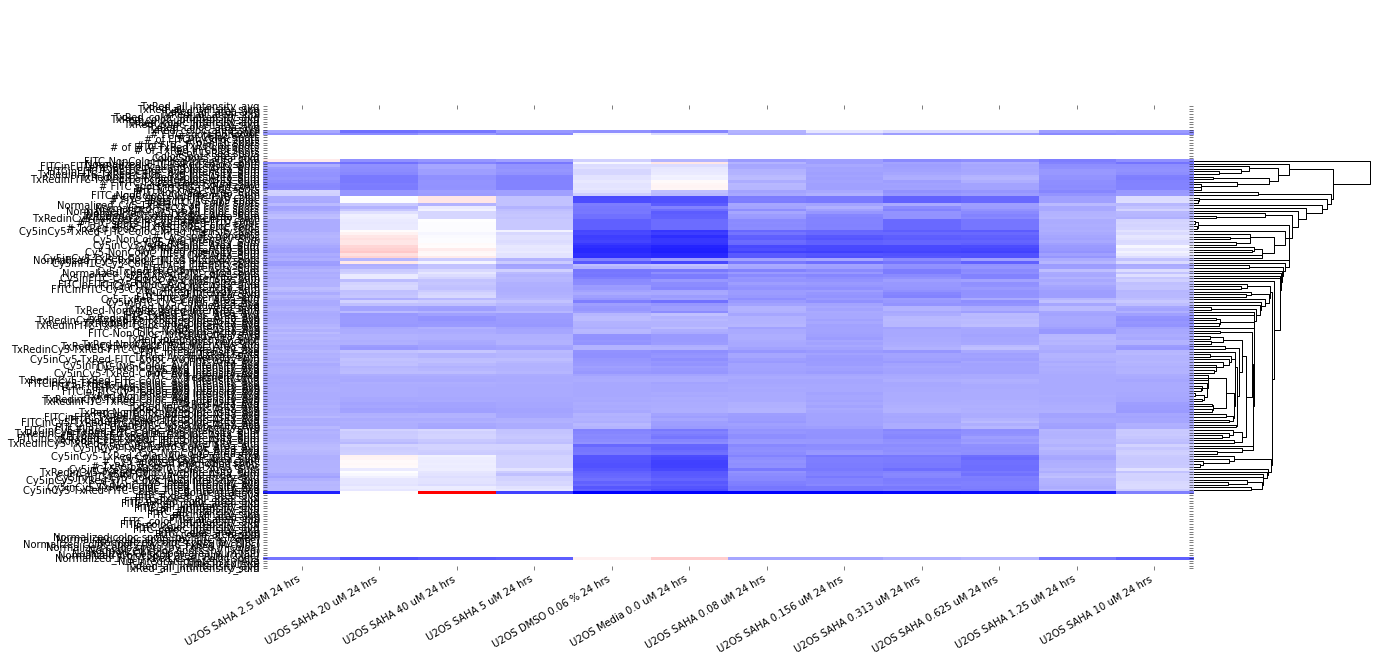

In [35]:
interact(matrix_tree, data = fixed(normalized_condition_data), color = get_color_widget());

---
# Heatmap subsets
The last selection box allows you to show parameters that are missing data. They shouldn't really affect clustering.

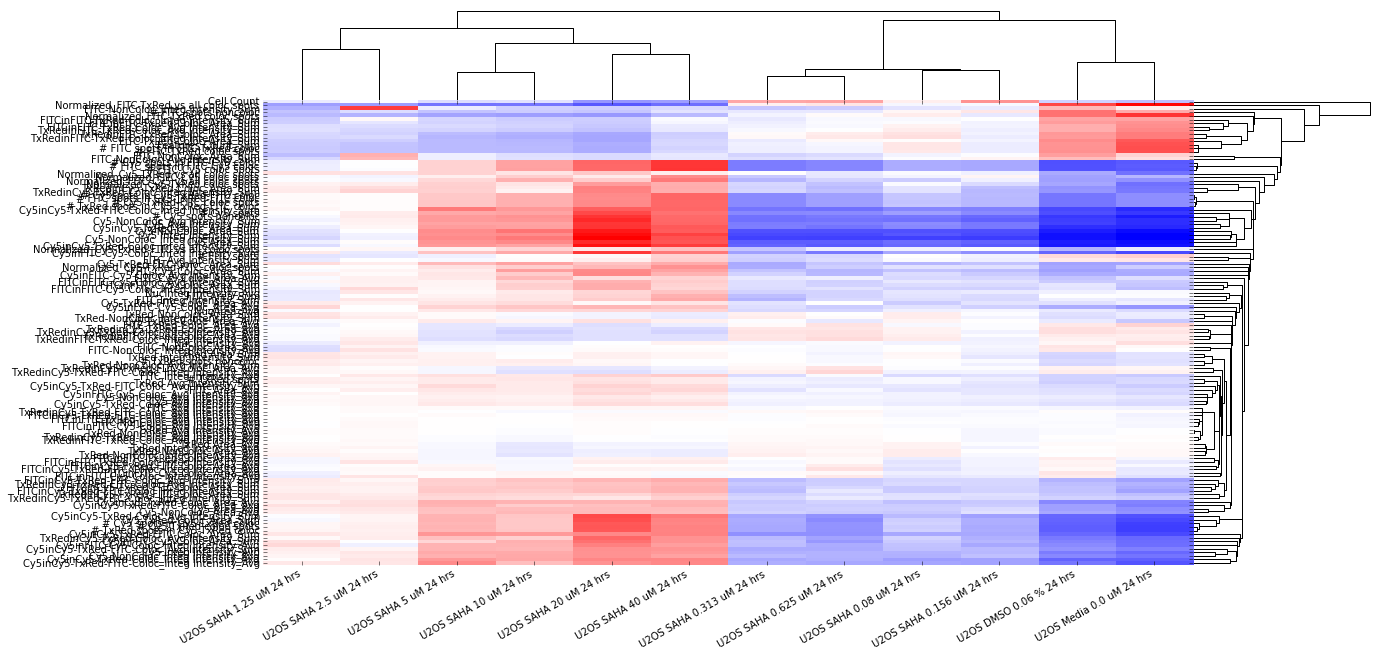

In [36]:
def wrapper(conditions,features,color):
    dataframe = normalized_condition_data.loc[list(conditions)][list(features)]
    try: 
        matrix_tree(dataframe,color)
    except:
        print "\n".join(["-"*50, "Please select multiple features and conditions.","-"*50])

interact(wrapper,
         conditions = get_condition_widget_multiple(),
         features = get_parameter_widget_multiple(),
         color = get_color_widget());

---
# Parameter vs. Conditions

In [37]:
def plot_dist(data,parameters):        
    fig = plt.figure(num=None, figsize=(15, 7), dpi=100, facecolor='w', edgecolor='k')
    
    reshaped_data = pd.concat([add_col(data[['Condition',parameter]].rename(columns={parameter: 'Value'}),'Parameter',parameter) for parameter in parameters])
    
    sns.boxplot(x = 'Condition',
                y = 'Value',
                hue = 'Parameter',
                data = reshaped_data,
                order = sorted(data.Condition.unique()))    
    
#     plt.ylabel(parameter,fontsize=20)
    plt.xlabel('Condition',fontsize=20)
    plt.title('Distribution: ' + parameter,fontsize=20)
    plt.tick_params(labelsize=10)
    plt.xticks(rotation=30,ha='right')
    mean = data[parameter].mean()
    plt.gca().set_ylim(bottom=data[parameter].mean() * -0.5)

In [38]:
def dist_wrapper(parameters,conditions):
    conditions = list(conditions)
    if list(parameters) == ['Cell Count']:
        dataframe = thread_first(wells,
                                 (filter_rows,'Condition',conditions))
        plot_dist(dataframe,parameters)
    else: 
        if 'Cell Count' in parameters:
            print "Ignoring cell count. Select it by itself if you want to see it."
        dataframe = filter_rows(cells,'Condition',conditions)
        plot_dist(dataframe,filter(lambda x: x != 'Cell Count',parameters))

In [39]:
# def my_beeswarm(dataframe,method = "center"):
#     cols = dataframe.columns.tolist()
#     positions = np.array(range(len(cols)))
#     beeswarm(dataframe.values.T,method=method,labels = cols,positions = positions)
#     fig = plt.gcf()
#     fig.set_size_inches(5,1)
    
# interact()

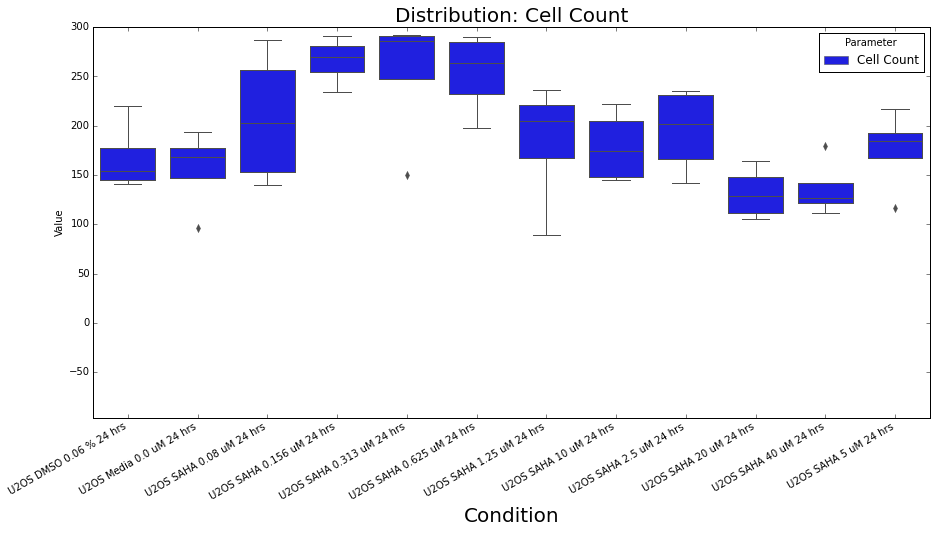

In [40]:
interact(dist_wrapper,
         parameters = get_parameter_widget_multiple(param_cols[:1]),
         conditions = get_condition_widget_multiple());

---
# Compare conditions

In [41]:
def compare_condition_dists(dataframe, conditions, parameters, bandwidth=0.1, shaded = True, clip_ends = False, scale='linear'):
    n_rows = int(np.ceil(len(parameters)/3.0))
    plt.figure(figsize=(20,4 * n_rows))
    subs = gridspec.GridSpec(n_rows, 3) 
    plt.subplots_adjust(hspace=0.54,wspace=0.27)

    for parameter,sub in zip(parameters,subs):
        plt.subplot(sub)
        param_bandwidth = bandwidth * dataframe[dataframe.Condition == conditions[0]][parameter].mean()
        for condition in conditions:
            data = dataframe[dataframe.Condition == condition][parameter]
            kws = {"shade": shaded, "bw": param_bandwidth}
            if clip_ends: 
                kws = assoc(kws,"cut",0)
            sns.distplot(data, hist=False, kde_kws=kws,label=condition)
            plt.legend(loc = 0,fontsize=8)
        if scale == 'linear':
            plt.xlim(left=0)
        else:
            plt.xscale('log')
        plt.ylabel('Frequency')

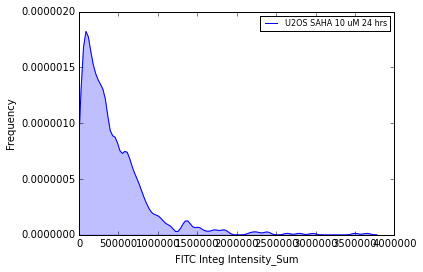

In [42]:
try:    
    interact(compare_condition_dists,
             dataframe = fixed(cells_with_phase),
             conditions = widgets.SelectMultiple(options = condition_names_with_phase,height = 300),
             parameters = widgets.SelectMultiple(options = param_cols,height = 300),
             bandwidth = (0,0.2,0.01),
             scale = widgets.ToggleButtons(options=['linear','log']));
except ValueError: 
    raise Exception("Hmm. That didn't work. Maybe one of the conditions or parameters you selected doesn't have any data.")

---
# Compare parameters

In [43]:
def compare_parameter_dists(dataframe, conditions, parameters, bandwidth=0.1, shaded = True, clip_ends = False, scale='linear'):
    n_rows = int(np.ceil(len(conditions)/3.0))
    plt.figure(figsize=(20,4 * n_rows))
    subs = gridspec.GridSpec(n_rows, 3) 
    plt.subplots_adjust(hspace=0.54,wspace=0.27)

    for condition,sub in zip(conditions,subs):
        plt.subplot(sub)
        condition_bandwidth = bandwidth * dataframe[dataframe.Condition == condition][parameters[0]].mean()
        for parameter in parameters:
            data = dataframe[dataframe.Condition == condition][parameter]
            kws = {"shade": shaded, "bw": condition_bandwidth}
            if clip_ends: 
                kws = assoc(kws,"cut",0)
            sns.distplot(data, hist=False, kde_kws=kws,label=parameter)
            plt.legend(loc = 0,fontsize=8)
        if scale == 'linear':
            plt.xlim(left=0)
        else:
            plt.xscale('log')
        plt.ylabel('Frequency')
        plt.xlabel(condition)

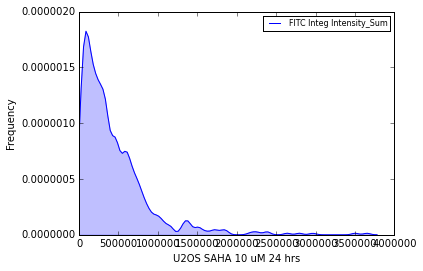

In [44]:
interact(compare_parameter_dists,
         dataframe = fixed(cells_with_phase),
         conditions = widgets.SelectMultiple(options = condition_names_with_phase,height = 300),
         parameters = widgets.SelectMultiple(options = param_cols,height = 300),
         bandwidth = (0,0.2,0.01),
         scale = widgets.ToggleButtons(options=['linear','log']));

In [45]:
def check_significance(data,control,comparisons,parameter):
    conditions = thread_last(
        data[['Condition',parameter]].groupby('Condition'),
        (map,lambda group: (group[0],group[1][parameter].values)),
        dict)
    control_data = conditions[control]
    results = [{'Condition':comparison,
                'D (KS test)':ks_2samp(control_data,conditions[comparison])[0],
                'P-value (KS test)': ks_2samp(control_data,conditions[comparison])[1],                
                'P-value (Wilcoxon rank-sum)': ranksums(control_data,conditions[comparison])[1]} \
               for comparison in comparisons]
    df = pd.DataFrame(results)
    print "Control: {}".format(control)
    display(df)
    df.set_index('Condition').plot(kind = 'bar')
    plt.title("Parameter: {}".format(parameter))

Control: U2OS DMSO 0.06 % 24 hrs


,Condition,D (KS test),P-value (KS test),P-value (Wilcoxon rank-sum)
0,U2OS SAHA 10 uM 24 hrs,0.671339,1.143042e-137,1.649720e-149


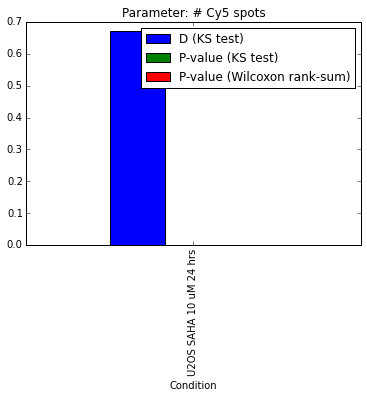

In [46]:
interact(
    check_significance,
    data = fixed(cells_with_phase),
    control = widgets.Select(options = condition_names_with_phase, height = 300),
    comparisons = widgets.SelectMultiple(options = condition_names_with_phase, height = 300),
    parameter = widgets.Select(options = param_cols_without_cell_count, height = 300));

---
#How are different parameters related?

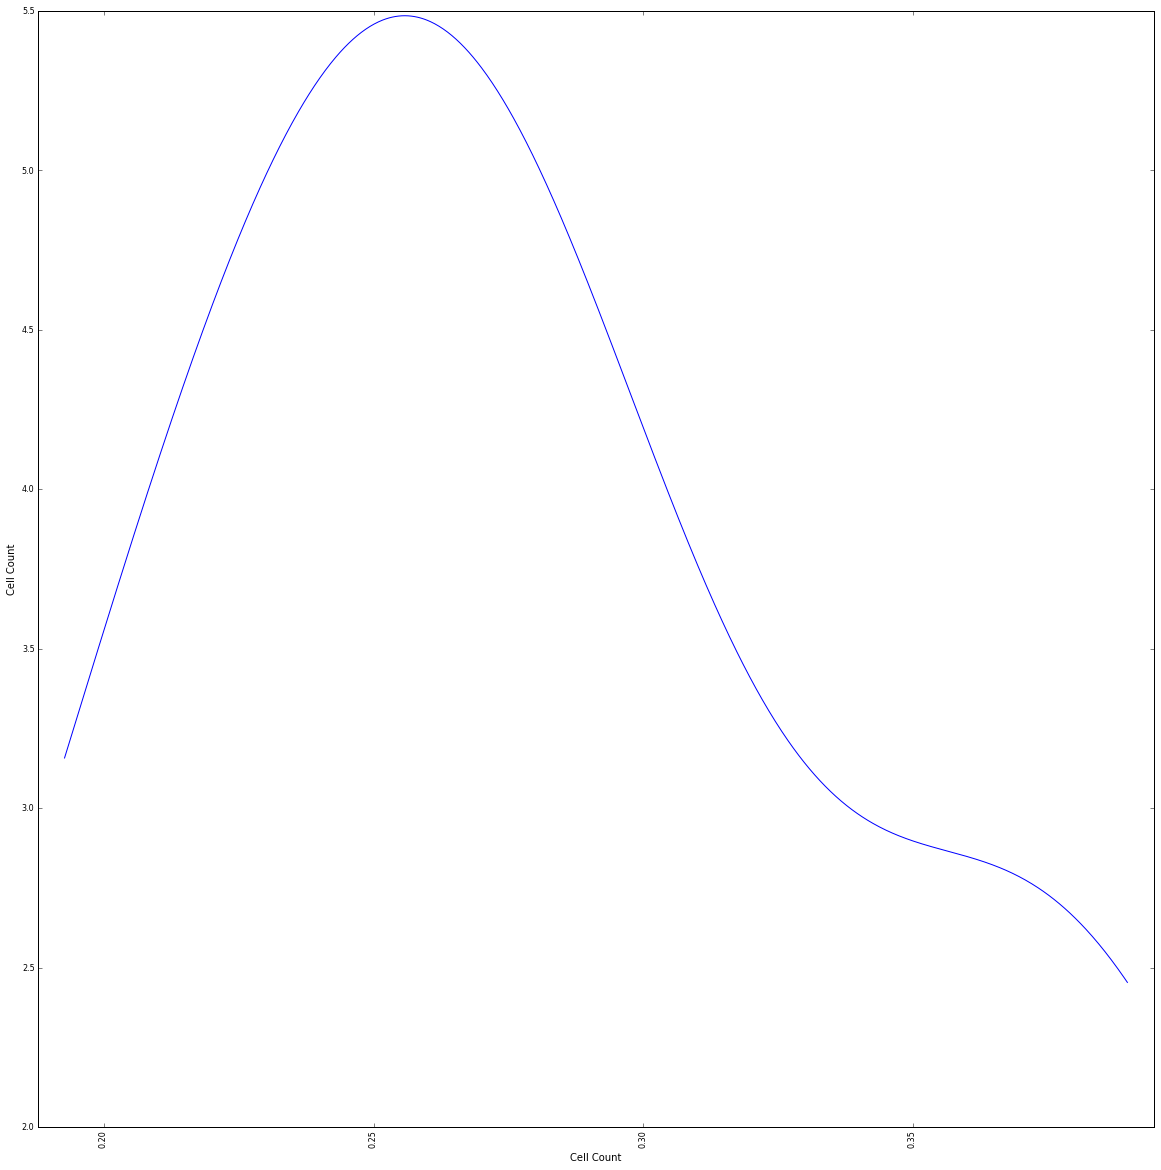

In [47]:
def scatter(dataframe,cols):
    scatter_matrix(dataframe[list(cols)], alpha=1, figsize=(20, 20), diagonal='kde');
    
interact(scatter, 
         dataframe = fixed(normalized_condition_data),
         cols = widgets.SelectMultiple(
            value = ['Cell Count'],
            options = param_cols,
            height=250));